<a href="https://colab.research.google.com/github/nabazar/ALPR_Dataset/blob/main/PathPlanningRLv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image as im
from gym import spaces
from numpy.matlib import repmat


In [78]:
class Agent():
    def __init__(self, env):
        self.env = env
        self.epsilon = 0.7
        self.alpha=0.5
        self.gamma=0.85

        self.Q_table=np.random.rand(env.num_states, 8)
        # for i in range(0,env.num_states):
        #   for j in range(0,8):
        #     self.Q_table[i,j]=float(np.random.rand(1))


    def updat_Q_value(self,st,nxtst,action,reward):

      self.Q_table[st][action]=self.Q_table[st][action]+self.alpha*(reward+self.gamma*np.max(self.Q_table[nxtst])-self.Q_table[st][action])
      # return self.Q_table

    def get_action(self,st):
        if np.random.random() < self.epsilon:
            # exploit

            ex=np.exp(self.Q_table[st])
            py=ex/sum(ex)

            return np.argmax(py)
        else:
            # explore
            return np.random.randint(8)




In [79]:
# from pickle import TUPLE1
class PathPlanningEnv():
  def __init__(self,A):
    self.A=A
    self.xmax=600
    self.xmin=0
    self.ymax=600
    self.ymin=0
    self.nx=A.shape[0]
    self.ny=A.shape[1]
    dx=(self.xmax-self.xmin)/(2*self.nx)
    dy=(self.ymax-self.ymin)/(2*self.ny)
    self.D=np.sqrt(dx**2+dy**2)
    # self.num_states = env.nx*env.ny*3
    self.num_states = self.nx*self.ny
    states=[]
    # kk=-1
    act=[(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(-1,1)]
    actions=[]
    for i in range(0,self.nx):
      for j in range(0,self.ny):
        # for k in range(0,3):
          # kk=kk+1
        states.append(tuple([i,j]))

          # states.append(tuple([i,j,k]))
        a=[]
        for ii in range(0,8):
          if act[ii][0]+i<self.nx and act[ii][1]+j<self.ny :
            a.append(ii)

        actions.append(tuple(a))
    self.states=states
    self.actions=actions

    self.action_space = spaces.Discrete(8)
    self.observation_space = spaces.Dict({
            "xr": spaces.Box(low = 0, high = self.nx, shape=(self.nx,), dtype=int),
            "yr": spaces.Box(low = 0, high = self.ny, shape=(self.ny,), dtype=int)})
    # self.observation_space = spaces.Dict({
    #         "xr": spaces.Box(low = 0, high = self.nx, shape=(self.nx,), dtype=int),
    #         "yr": spaces.Box(low = 0, high = self.ny, shape=(self.ny,), dtype=int),
    #         "obs_situ": spaces.Box(low = 0, high = 3, shape=(3,), dtype=int)})

  def reset(self):
    self.xr = np.random.randint(self.nx)
    self.yr = np.random.randint(self.ny)
    # self.obs_situ =np.random.randint(3)
    while self.A.iloc[self.xr,self.yr]==0:
      self.xr = np.random.randint(self.nx)
      self.yr = np.random.randint(self.ny)
    state=self.get_observation()

    return state
  def get_observation(self):

    observation=(int(self.xr),int(self.yr))
    # observation=(int(self.xr),int(self.yr),int(self.obs_situ))

    return observation

  def step(self,action):
    next_state=self.get_observation()
    if action==0:
      self.xr=self.xr+1
      self.yr=self.yr+1
    elif action==1:
      self.xr=self.xr+1
      self.yr=self.yr+1
    elif action==2:
      self.xr=self.xr+1
      self.yr=self.yr+1
    elif action==3:
      self.xr=self.xr-1
      self.yr=self.yr+1
    elif action==4:
      self.xr=self.xr-1
      self.yr=self.yr+0
    elif action==5:
      self.xr=self.xr-1
      self.yr=self.yr-1
    elif action==6:
      self.xr=self.xr+0
      self.yr=self.yr-1
    elif action==7:
      self.xr=self.xr+1
      self.yr=self.yr-1
    flag=0
    done=0

    if self.xr>=self.nx or self.yr>=self.ny:
      flag=1
      reward=-25
    else:
      if self.xr==self.goal[0] and self.yr==self.goal[1]:
          reward=25
          flag=1
          done=1
      elif self.A.iloc[self.xr,self.yr]==255:
          reward=-10
      else:
          reward=-1

      next_state=self.get_observation()

    return next_state,reward,done,flag
  def state2index(self,state):
    if (state[0],state[1]) in self.states:
      state_index = self.states.index((state[0],state[1]))

    else:
      state_index=[]

    return state_index



  def render(self):

    fig=plt.figure(figsize=(3,3))
    clear_output(wait=True)
    plt.subplot(2,1,1)
    plt.plot(env.start[1],env.start[0],'-or')
    plt.plot(env.goal[1],env.goal[0],'-og')
    xp=[]
    yp=[]
    for i in range(0, len(env.Path)):
      xp.append(env.Path[i][0])
      yp.append(env.Path[i][1])
    plt.plot(yp,xp,'-b')
    plt.plot(yp[0],xp[0],'-om')
    plt.plot(yp[-1],xp[-1],'-oc')
    plt.xlim([0,env.ny])
    plt.ylim([0,env.nx])
    plt.imshow(env.A)
    plt.show()

    plt.subplot(2, 1,2)
    plt.plot(self.rewards,'-b')
    clrs = ['red' if (x < 0) else 'green' for x in self.ep_reward]
    x=np.linspace(0,len(self.ep_reward),len(self.ep_reward))
    plt.bar(x, self.ep_reward, color=clrs)
    plt.xlabel('Iterations')
    plt.ylabel('Rewards')
    plt.show()





In [80]:
A = pd.read_csv('/content/Map20x20.csv')

In [81]:
env=PathPlanningEnv(A)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
agent=Agent(env)

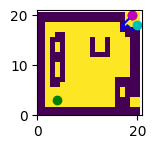

In [ ]:
max_episode=200000
episode=0
env.goal= [int(3),int(4)]
env.A.iloc[env.goal[0],env.goal[1]]=100
env.ep_reward=[]
env.rewards=[]
while episode<=max_episode:
  # A0=env.A
  state=env.reset()
  env.state=state
  flag=0
  max_stp=50
  stp=0

  step_reward=[]
  env.start=[state[0],state[1]]

  Path=[]
  while flag==0 and stp<=max_stp:
    env.xr=int(state[0])
    env.yr=int(state[1])
    Path.append((env.xr,env.yr))

    # env.obs_situ=state[2]
    env.state=state
    st=env.state2index(state)
    action=agent.get_action(st)
    if action in env.actions[st] :

      next_state,reward,done,flag=env.step(action)
    else:
      next_state,reward,done,flag=state,-25,0,1
    nxtst=env.state2index(next_state)
    if nxtst !=[]:
      agent.updat_Q_value(st,nxtst,action,reward)
    else:
     flag=1
    state=next_state
    Path.append((env.xr,env.yr))
    env.Path=Path


    stp=stp+1
    step_reward.append(reward)
  env.ep_reward.append(np.mean(step_reward))
  env.rewards.append(np.mean(env.ep_reward))
  if episode%1000==0:
    env.render()

  episode=episode+1

